# ***Algoritmo MUSCLE para el alineamiento de múltiples secuencias***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
import json

**Subir archivo con secuencias en formato FASTA**

In [2]:
from google.colab import files

uploaded = files.upload()
filename = next(iter(uploaded))

Saving Prueba_cuboB.fasta to Prueba_cuboB.fasta


Contador de:
*   Secuencias
*   Tamaño de cada secuencia





In [3]:
def tamañoseq(filename):
    with open(filename, 'r') as file:
        sequences = []
        sequence = ''
        for line in file:
            if line.startswith('>'):
                if sequence:
                    sequences.append(len(sequence))
                    sequence = ''
                continue
            sequence += line.strip()
        if sequence:
            sequences.append(len(sequence))
    return len(sequences), sequences

# Aplicando función
num_sequences, sizes = tamañoseq(filename)
print(f"There are {num_sequences} sequences in the file.")
print("Sizes of the sequences:", sizes)

There are 45 sequences in the file.
Sizes of the sequences: [40, 30, 35, 37, 37, 36, 34, 38, 33, 39, 36, 32, 37, 38, 31, 37, 34, 36, 32, 35, 37, 33, 34, 38, 32, 37, 32, 38, 35, 36, 32, 37, 37, 31, 34, 33, 39, 37, 36, 31, 34, 38, 32, 33, 39]


Extraer secuencias del archivo

In [4]:
def process_uploaded_file(uploaded_file, truncate=False, percentage=100):
    sequences = []
    sequence = ''
    header = None
    for line in uploaded_file.decode('utf-8').splitlines():
        if line.startswith('>'):
            if sequence:
                sequences.append((header, sequence))
                sequence = ''
            header = line[1:].strip()  # Remove '>' and extract header
        else:
            sequence += line.strip()
    if sequence:  # To handle the last sequence in the file
        sequences.append((header, sequence))

    # Truncate sequences if required
    if truncate:
        truncated_sequences = []
        for header, seq in sequences:
            truncated_length = int(len(seq) * (percentage / 100))
            truncated_sequences.append((header, seq[:truncated_length]))
        sequences = truncated_sequences

    return sequences

**Preguntar si se cortará una parte de la secuencia**

In [5]:
file_content = uploaded[filename]

# Preguntar al usuario si desea truncar las secuencias
truncate_answer = input("¿Deseas truncar las secuencias antes de alinearlas? (yes/no): ").lower()
truncate = False
percentage = 100

if truncate_answer == 'yes':
    truncate = True
    percentage = float(input("Porcentaje de la secuencia a considerar (1-100): "))

# Procesar el archivo y opcionalmente truncar las secuencias
processed_sequences = process_uploaded_file(file_content, truncate, percentage)

# Guardar las secuencias procesadas en un nuevo archivo
new_filename = "processed_sequences.fasta"
with open(new_filename, "w") as file:
    for header, seq in processed_sequences:
        file.write(f">{header}\n")  # Encabezado en formato FASTA con símbolo '>'
        for i in range(0, len(seq), 60):  # Escribir la secuencia en líneas de hasta 60 caracteres
            file.write(f"{seq[i:i+60]}\n")
        file.write("\n")

# Imprimir cada secuencia y su tamaño
for header, seq in processed_sequences:
    print(header)
    print(seq)  # La secuencia ya incluirá los saltos de línea correctamente
    print(f"Tamaño: {len(seq)}\n")  # Añade una nueva línea para separar cada secuencia

¿Deseas truncar las secuencias antes de alinearlas? (yes/no): no
ACCN|OP369336   OP369336.1
ATTAAAGGTTTACCTTCCCAGGTAACAAACCGTAACAAAC
Tamaño: 40

ACCN|OP370189   OP370189.1
ATTAAAGGTTTATACCTTCCCAGGTAACAA
Tamaño: 30

ACCN|OP370368   OP370368.1
AACTTTTGATCTCTTGTAGATCTGTTCTCTAAACG
Tamaño: 35

ACCN|OP370567   OP370567.1
TAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGC
Tamaño: 37

ACCN|OP370963   OP370963.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACC
Tamaño: 37

ACCN|OP371225   OP371225.1
ACCTTCCCAGGTAACAAACCAACCAACTTTTGATCT
Tamaño: 36

ACCN|OP371590   OP371590.1
AGGTTTATACCTTCCCAGGTAACAAACCAACCAA
Tamaño: 34

ACCN|OP371823   OP371823.1
ATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCT
Tamaño: 38

ACCN|OP371874   OP371874.1
ACTTTTGATCTCTTGTAGATCTGTTCTCTAAAC
Tamaño: 33

ACCN|OP372408   OP372408.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAA
Tamaño: 39

ACCN|OP372457   OP372457.1
TAAAGGTTTATACCTTCCCAGGTAACAAACCAACCA
Tamaño: 36

ACCN|OP372514   OP372514.1
TACCTTCCCAGGTAACAAACCAACCAACTTTT
Tamaño: 32

ACCN|OP399079   OP399079.1
T

In [6]:
if truncate_answer == 'yes':
    filename=new_filename

**Instalando y Ejecutando MUSCLE**

In [7]:
!sudo apt-get install muscle

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  muscle
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 244 kB of archives.
After this operation, 709 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 muscle amd64 1:3.8.1551-2build1 [244 kB]
Fetched 244 kB in 0s (995 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package muscle.
(Reading database ... 120882 files and directories curr

Utilizar una cantidad "n" de secuencias a alinear

In [8]:
def seqseleccionadas(original_filename, selected_filename, num_sequences):
    """
    Crea un archivo FASTA con un número específico de secuencias seleccionadas
    del archivo FASTA original.

    Parameters:
    original_filename (str): Nombre del archivo original FASTA.
    selected_filename (str): Nombre del archivo a crear con las secuencias seleccionadas.
    num_sequences (int): Número de secuencias a seleccionar.
    """
    with open(original_filename, 'r') as original_file, open(selected_filename, 'w') as selected_file:
        sequence_count = 0
        for line in original_file:
            if line.startswith('>'):
                if sequence_count >= num_sequences:
                    break
                sequence_count += 1
            selected_file.write(line)

Función MUSCLE

In [9]:
def muscle_alignment(infile, outfile):
    get_ipython().system(f'muscle -in {infile} -out {outfile}')

Tamaño de las secuencias a alinear

In [10]:
def get_alignment_lengths(alignment_file):
    with open(alignment_file, 'r') as f:
        lengths = []
        sequence = ''
        for line in f:
            if line.startswith('>'):
                if sequence:
                    lengths.append(len(sequence))
                    sequence = ''
            else:
                sequence += line.strip()
        if sequence:  # Para la última secuencia en el archivo
            lengths.append(len(sequence))
    return lengths

Scoring

In [11]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.3 MB/s eta 0:00:00


In [12]:
from Bio import AlignIO
import numpy as np

def calculate_consensus(fasta_file):
    # Leer el alineamiento del FASTA file
    alignment = AlignIO.read(fasta_file, "fasta")

    sequences = [str(record.seq) for record in alignment]
    sequences_transpo = np.transpose(sequences)

    score = 0
    for column in sequences_transpo:
        unique_nucleotides = set(column)
        unique_nucleotides.discard('-')  # Excluir gaps

        if '-' in column:
            score += 3
        elif len(unique_nucleotides) > 1:
            if unique_nucleotides.issubset({'A', 'G'}) or unique_nucleotides.issubset({'T', 'C'}):
                score += 1
            else:
                score += 2

    # Normalizar el score por la secuencia más larga
    max_length = max(len(seq) for seq in sequences)
    normalized_score = score / max_length

    return normalized_score

Implementación de todas las funciones

In [ ]:
# Batches para el alineamiento
batches = [2, 5, 10, 15, 20, 25]

# Número de veces para cada tamaño de lote
num_trials = 10

means = []
std_devs = []

for batch in batches:
    batch_times = []

    for trial in range(1, num_trials + 1):
        selected_sequences_file = f'selected_sequences_batch{batch}_trial{trial}.fasta'
        output_file = f'aligned_batch{batch}_trial{trial}.fasta'

        # Crear archivo con un subconjunto de secuencias
        seqseleccionadas(filename, selected_sequences_file, batch)

        # Medir el tiempo de alineamiento con MUSCLE
        start_time = time.time()
        muscle_alignment(selected_sequences_file, output_file)
        end_time = time.time()

        batch_times.append(end_time - start_time)

        # Obtener las longitudes de las secuencias alineadas
        sequence_lengths = get_alignment_lengths(selected_sequences_file)

        # Obtener el puntaje de las secuencias alineadas
        sequence_score = calculate_consensus(output_file)

        # Estructura de datos para JSON
        data_to_save = {
            "Numero de Secuencias": batch,
            "Longitud de Secuencias": sequence_lengths,
            "Alineamiento": {
                "Score": sequence_score,  # INCLUIR DESVIACION ESTANDAR
                "Tiempo": end_time - start_time
            },
            "Algoritmo": "MUSCLE"
        }

        # Serializar los datos a JSON
        json_filename = f'results_batch{batch}_trial{trial}.json'
        with open(json_filename, 'w') as json_file:
            json.dump(data_to_save, json_file, indent=4)

    means.append(np.mean(batch_times))
    std_devs.append(np.std(batch_times))

**Mostrar alineamiento**

In [ ]:
# Mostrar el contenido del archivo alineado
# with open('output.fasta', 'r') as f:
    #print(f.read())

**Mostrar gráfica de tiempo computacional por alineamiento**

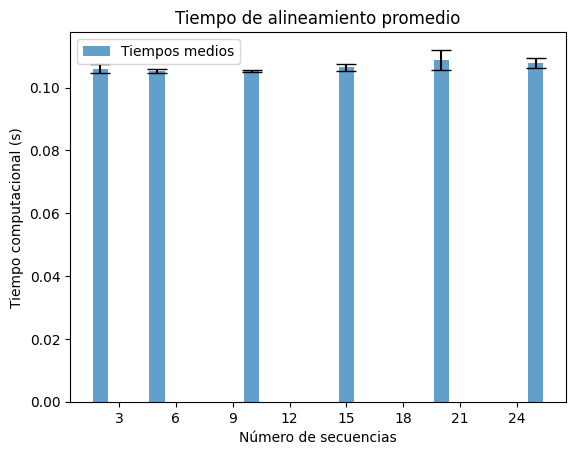

In [14]:
# Imprimir y graficar los resultados como antes
# print("Tiempos medios por tamaño de lote:", means)
# print("Desviaciones estándar por tamaño de lote:", std_devs)

# Graficar los resultados
plt.bar(batches[:len(means)], means, yerr=std_devs, alpha=0.7, label="Tiempos medios", capsize=7)
plt.xlabel('Número de secuencias')
plt.ylabel('Tiempo computacional (s)')
plt.title('Tiempo de alineamiento promedio')
plt.legend()

# Ajustar los ticks del eje X para que solo muestre enteros
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()